In [12]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
# %matplotlib notebook
import numpy as np
import os
import random

In [36]:
files = []
datapath = '../../data/master_tables/'
for i in os.listdir(datapath):
    if 'processed3' in i:
        files.append(i)

In [37]:
len(files)

6

In [38]:
files

['hamilton_miranda_processed3.tsv',
 'kuroko_no_basuke_processed3.tsv',
 'les_miserables_all_media_types_processed3.tsv',
 'les_miserables_schonberg_boublil_processed3.tsv',
 'shakespare_william_works_processed3.tsv',
 'the_walking_dead_&_related_fandoms_processed3.tsv']

Make scatter plot for all datasets

In [39]:
def plot_scatter(fandom_list, field):
    names = []
    Kudos_ind_dict_all = {}
    for i in fandom_list:
        name = i.split('.')[0].replace('_processed3', '')
        names.append(name)
        df = pd.read_csv(datapath + i, sep = '\t')
        df = df.drop(df.index[[0, 1]])
        df = df.apply(lambda x: pd.to_numeric(x, errors='ignore'))
        
#         use KL squared
#         df['KL_squared'] = df['KL']**2

        # Turn Kudos and pub date into z-scores.
        for i in ['Kudos', field]:
            df[i] = (df[i].astype(float) - df[i].astype(float).mean())/df[i].astype(float).std(ddof=0)
        Kudos_ind_dict = dict(zip(df[field], df['Kudos']))
        Kudos_ind_dict_all[name] = Kudos_ind_dict
#     print Kudos_ind_dict_all.keys()
        
    fig, axs = plt.subplots(2,4, figsize=(20, 10))
    axs = axs.ravel()
    for i in range(0, len(fandom_list)):
        x = sorted(Kudos_ind_dict_all[names[i]].keys())
        y = [Kudos_ind_dict_all[names[i]][j] for j in x]
        axs[i].scatter(x, y, s=5)
#         axs[i].plot(x, y)
        axs[i].set_title(names[i])
    fig.text(0.5, 0.04, 'Kudos', ha='center', va='center')
    fig.text(0.06, 0.5, field, ha='center', va='center', rotation='vertical')
#     plt.savefig(field + '_kudos_all.png', format = 'png')
    

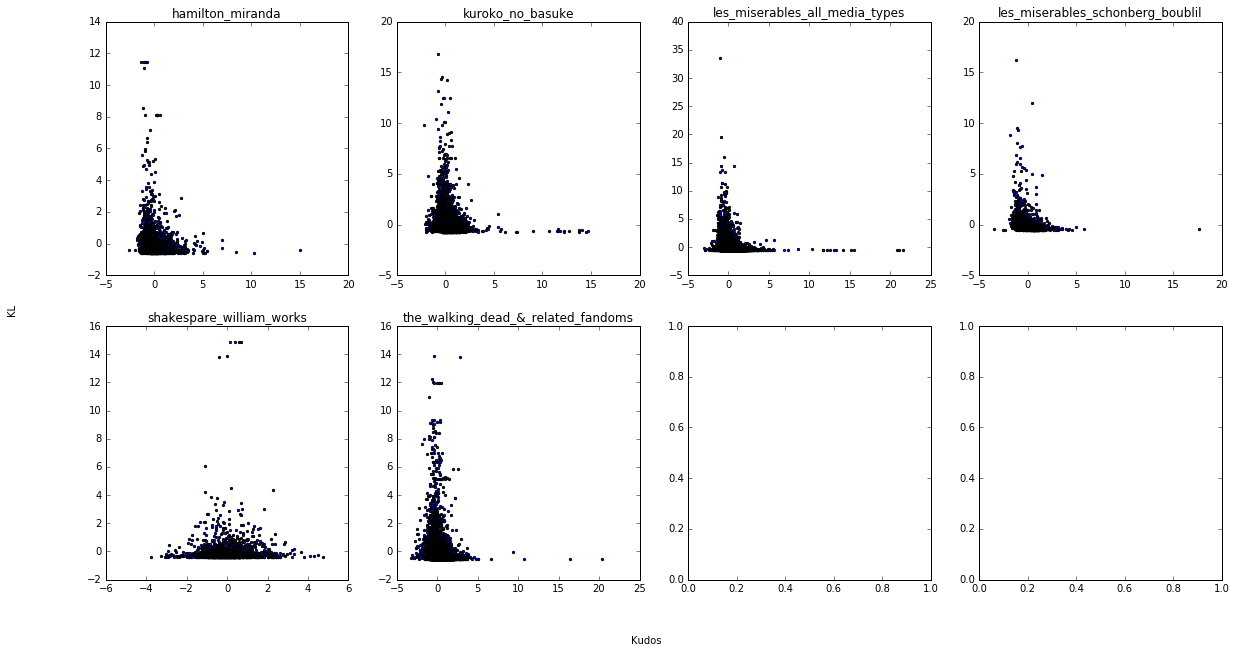

In [40]:
plot_scatter(files,'KL')

Make scatter plot w error bars w bootstrapping

In [41]:
def bootstrap_resample(li):
    if len(li) > 0:
        ave_original = np.average(li)
        aves = []
        for i in range(1000):
            sample = []
            for i in range(len(li)):
                sample.append(random.choice(li))
            aves.append(np.average(sample))
        tail = sorted(aves)[24]
        head = sorted(aves)[970]
    else:
        ave_original = 0
        tail = 0
        head = 0
    return (ave_original, tail, head)

In [44]:
def kl_kudos_scatter(fandom_list, binsize):
    kk_dict_all = {}
    names = []
    for i in fandom_list:
        name = i.split('.')[0].replace('_processed3', '')
        names.append(name)
        df = pd.read_csv(datapath + i, sep = '\t')
        df = df.drop(df.index[[0, 1]])
        df = df.apply(lambda x: pd.to_numeric(x, errors='ignore'))
        for i in ['Kudos', 'KL']:
            df[i] = (df[i].astype(float) - df[i].astype(float).mean())/df[i].astype(float).std(ddof=0)

    #     Make bins
        min_kl = int(min(df.KL.tolist())) -1
        max_kl = int(max(df.KL.tolist())) +1
        kk_dict = {}
        for i in np.arange(min_kl, max_kl, binsize):
            df_s = df[(df.KL >= i) & (df.KL < i+binsize)]
            kk_dict[i] = bootstrap_resample(df_s.Kudos.tolist())
        kk_dict_all[name] = kk_dict

    fig, axs = plt.subplots(2,4, figsize=(20, 10))
    axs = axs.ravel()

    for i in range(0, len(fandom_list)):
        x = sorted(kk_dict_all[names[i]].keys())
        y = [kk_dict_all[names[i]][j][0] for j in x]

        lower_error = [kk_dict_all[names[i]][j][0]-kk_dict_all[names[i]][j][1] for j in x]
        upper_error = [kk_dict_all[names[i]][j][2]-kk_dict_all[names[i]][j][0] for j in x]
        asymmetric_error = [lower_error, upper_error]

#         axs[i].errorbar(x, y, yerr=asymmetric_error,fmt='o')
        axs[i].plot(x, y, 'o-')
        axs[i].set_title(names[i])
        axs[i].set_xlim([min(x) -1, max(x) + 1])
        axs[i].set_ylim([min(y) -0.2, max(y) + 0.2])

    fig.text(0.5, 0.04, 'KLs', ha='center', va='center')
    fig.text(0.06, 0.5, 'Kudos', ha='center', va='center', rotation='vertical')
    plt.savefig('kl_squared_kudos_all_bin_0_5_ave_errorbar_single_topic.png', format = 'png')

    # ax.set_yscale('log')

    # ax.set_ylim([0.180, 0.225])

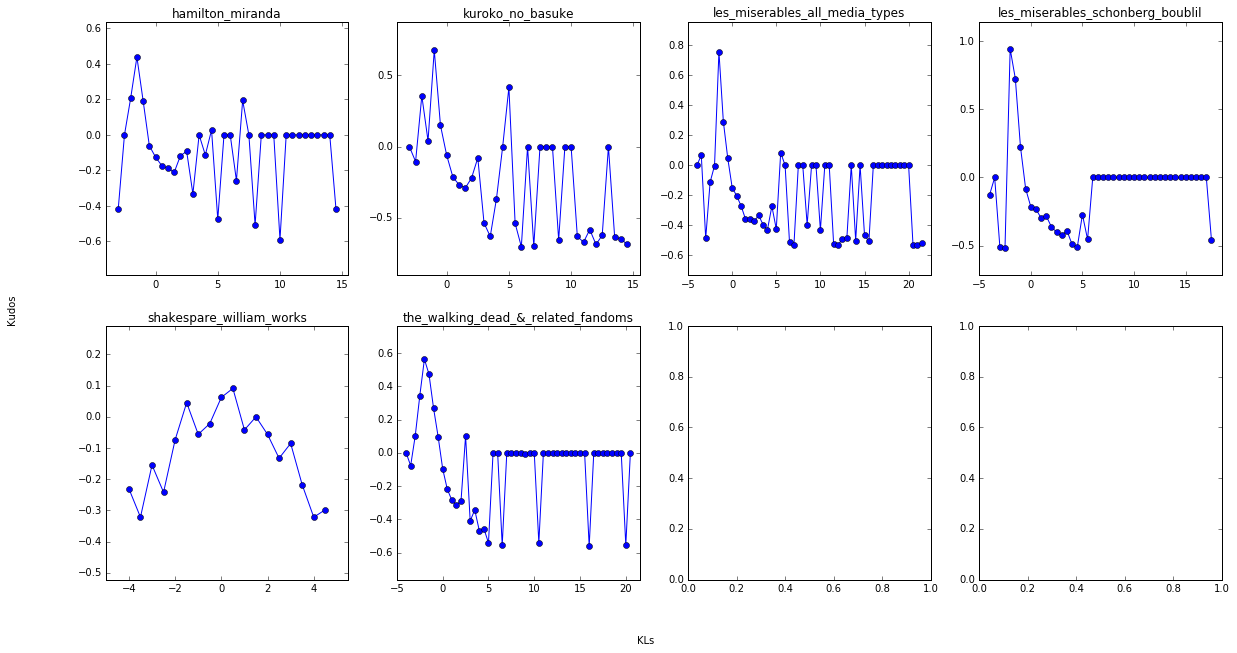

In [45]:
kl_kudos_scatter(files, 0.5)